# Text and Sequence Assignment 4

**Downloading and Preparing the IMDB Dataset**



In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  17.7M      0  0:00:04  0:00:04 --:--:-- 19.3M




```
# This is formatted as code
```

**Preparing the Text Data for Analysis**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir= pathlib.Path("/content/aclImdb")
val_dir = base_dir/ "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True )

    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
).take(100)

val_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batch_size
).take(10000)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Converting Text Sequences into Vectors**

In [3]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Baseline Model: One-Hot Encoded Vector Model**

In [4]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                2568448   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2568513 (9.80 MB)
Trainable params: 2568513 (9.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

**One Hot Model**

Epoch 1/10
100/100 [==============================] - 25s 194ms/step - loss: 0.6921 - accuracy: 0.5147 - val_loss: 0.6905 - val_accuracy: 0.5176
Epoch 2/10
100/100 [==============================] - 16s 159ms/step - loss: 0.6499 - accuracy: 0.6341 - val_loss: 0.5769 - val_accuracy: 0.7306
Epoch 3/10
100/100 [==============================] - 15s 149ms/step - loss: 0.5072 - accuracy: 0.7828 - val_loss: 0.5009 - val_accuracy: 0.7840
Epoch 4/10
100/100 [==============================] - 16s 164ms/step - loss: 0.3906 - accuracy: 0.8528 - val_loss: 0.4516 - val_accuracy: 0.7996
Epoch 5/10
100/100 [==============================] - 19s 190ms/step - loss: 0.3086 - accuracy: 0.8916 - val_loss: 0.4252 - val_accuracy: 0.8096
Epoch 6/10
100/100 [==============================] - 7s 65ms/step - loss: 0.2555 - accuracy: 0.9172 - val_loss: 0.6122 - val_accuracy: 0.7722
Epoch 7/10
100/100 [==============================] - 9s 87ms/step - loss: 0.2072 - accuracy: 0.9388 - val_loss: 0.4538 - val_accura

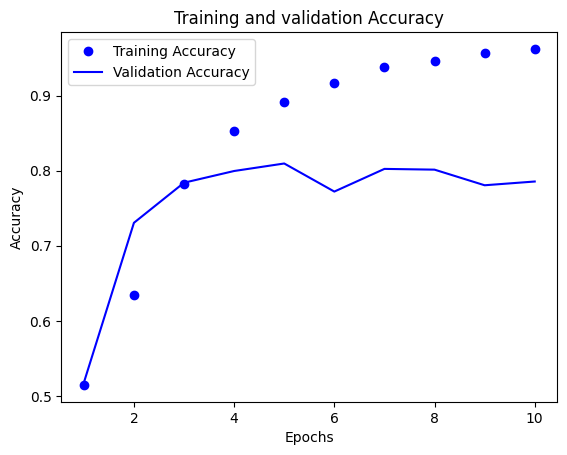

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.x",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("one_hot_bidir_lstm.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Creating the Embedding Layer**


In [6]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

**Model Incorporating Trainable Embedding Layer**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

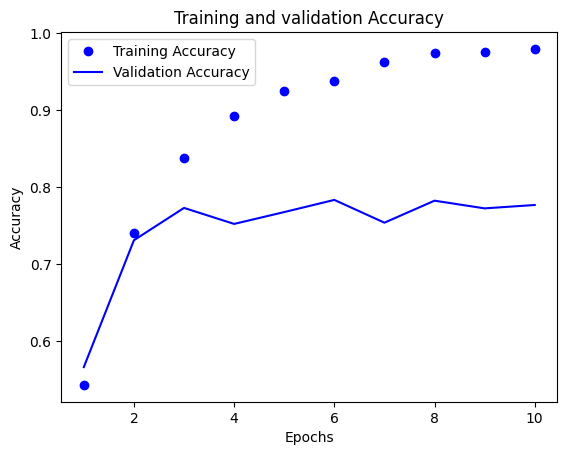

In [7]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.x",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs,accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Applying Masking to Padded Sequences within the Embedding Layer**

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2634049 (10.05 MB)
Trainable params: 2634049 (10.05 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

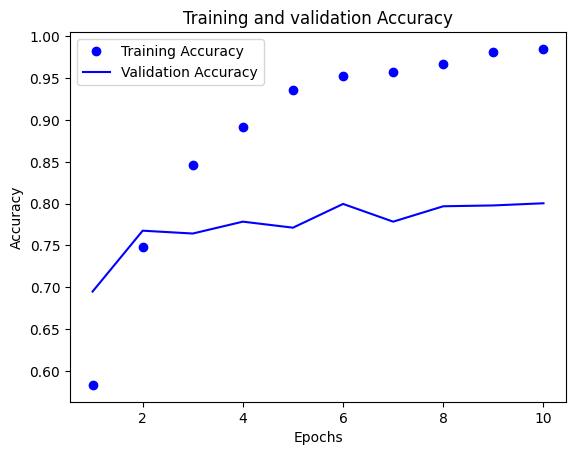

In [8]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.x",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Leveraging Pre-trained Word Embeddings (GloVe)**

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-05-05 22:28:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-05 22:28:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-05 22:28:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Parsing GloVe Data**

In [10]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Configuring Matrix for GloVe Vocabulary**

In [11]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Utilizing Pretrained GloVe Embeddings in the Model**

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1034113 (3.94 MB)
Trainable params: 34113 (133.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________

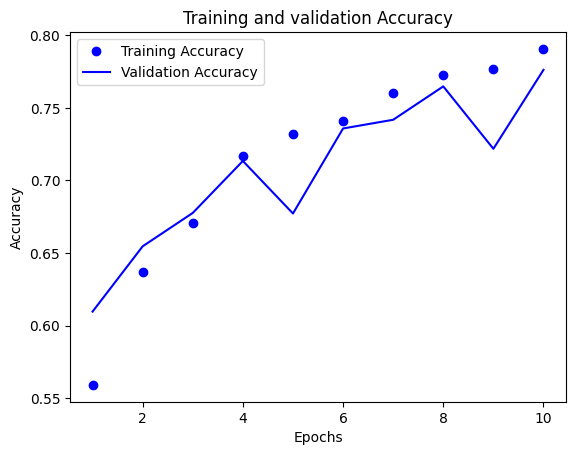

In [13]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.x",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.x")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.figure()
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Evaluating Model Performance Across Varied Training Set Sizes**

Found 20000 files belonging to 2 classes.
Epoch 1/10
100/100 [==============================] - 32s 267ms/step - loss: 0.6920 - accuracy: 0.5169 - val_loss: 0.6901 - val_accuracy: 0.5406
Epoch 2/10
100/100 [==============================] - 28s 278ms/step - loss: 0.6383 - accuracy: 0.6591 - val_loss: 0.5670 - val_accuracy: 0.7368
Epoch 3/10
100/100 [==============================] - 22s 218ms/step - loss: 0.4978 - accuracy: 0.7812 - val_loss: 0.5159 - val_accuracy: 0.7460
Epoch 4/10
100/100 [==============================] - 17s 168ms/step - loss: 0.3494 - accuracy: 0.8622 - val_loss: 0.4320 - val_accuracy: 0.8018
Epoch 5/10
100/100 [==============================] - 6s 64ms/step - loss: 0.2710 - accuracy: 0.9031 - val_loss: 0.4690 - val_accuracy: 0.7754
Epoch 6/10
100/100 [==============================] - 4s 39ms/step - loss: 0.1980 - accuracy: 0.9306 - val_loss: 0.6439 - val_accuracy: 0.7756
Epoch 7/10
100/100 [==============================] - 3s 35ms/step - loss: 0.1584 - accuracy

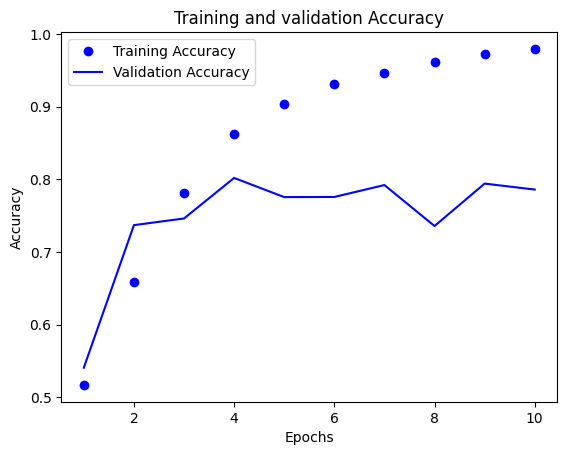

Epoch 1/10
100/100 [==============================] - 42s 334ms/step - loss: 0.6907 - accuracy: 0.5466 - val_loss: 0.6542 - val_accuracy: 0.6186
Epoch 2/10
100/100 [==============================] - 33s 328ms/step - loss: 0.6349 - accuracy: 0.6344 - val_loss: 0.5908 - val_accuracy: 0.7086
Epoch 3/10
100/100 [==============================] - 6s 57ms/step - loss: 0.5900 - accuracy: 0.6969 - val_loss: 0.6042 - val_accuracy: 0.6728
Epoch 4/10
100/100 [==============================] - 30s 299ms/step - loss: 0.5648 - accuracy: 0.7016 - val_loss: 0.5320 - val_accuracy: 0.7402
Epoch 5/10
100/100 [==============================] - 37s 375ms/step - loss: 0.5406 - accuracy: 0.7331 - val_loss: 0.5084 - val_accuracy: 0.7564
Epoch 6/10
100/100 [==============================] - 32s 324ms/step - loss: 0.5173 - accuracy: 0.7519 - val_loss: 0.5015 - val_accuracy: 0.7548
Epoch 7/10
100/100 [==============================] - 3s 31ms/step - loss: 0.4979 - accuracy: 0.7616 - val_loss: 0.5406 - val_accura

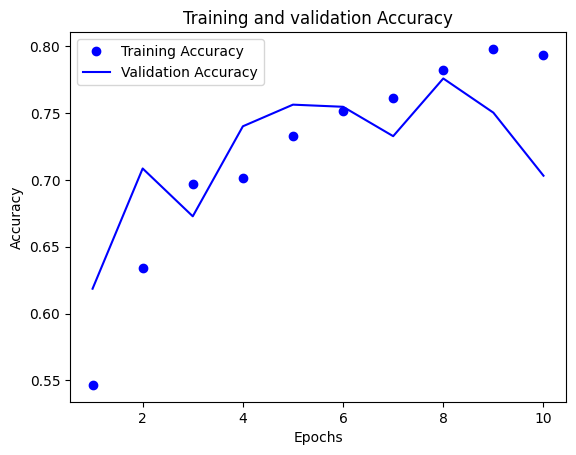

Training samples: 100
Embedding layer test accuracy: 0.798
Pretrained embeddings test accuracy: 0.769
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
500/500 [==============================] - 45s 84ms/step - loss: 0.5319 - accuracy: 0.7266 - val_loss: 0.4241 - val_accuracy: 0.8110
Epoch 2/10
500/500 [==============================] - 37s 74ms/step - loss: 0.3497 - accuracy: 0.8612 - val_loss: 0.3608 - val_accuracy: 0.8418
Epoch 3/10
500/500 [==============================] - 18s 36ms/step - loss: 0.2923 - accuracy: 0.8855 - val_loss: 0.4227 - val_accuracy: 0.8110
Epoch 4/10
500/500 [==============================] - 20s 40ms/step - loss: 0.2498 - accuracy: 0.9091 - val_loss: 0.3675 - val_accuracy: 0.8464
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 0.2191 - accuracy: 0.9210 - val_loss: 0.4223 - val_accuracy: 0.8272
Epoch 6/10
500/500 [==============================] - 10s 20ms/step - loss: 0.1904 - 

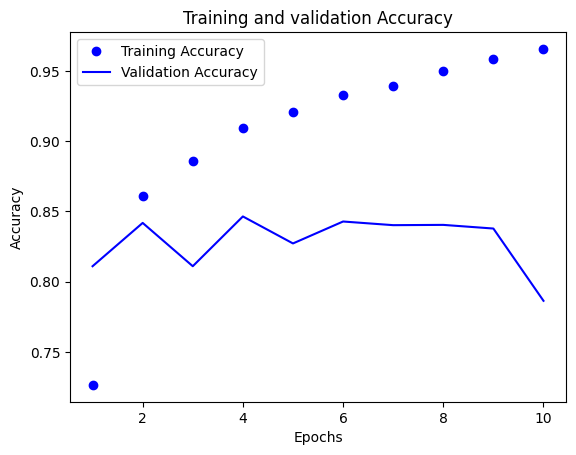

Epoch 1/10
500/500 [==============================] - 55s 91ms/step - loss: 0.6170 - accuracy: 0.6469 - val_loss: 0.5210 - val_accuracy: 0.7524
Epoch 2/10
500/500 [==============================] - 16s 33ms/step - loss: 0.4945 - accuracy: 0.7673 - val_loss: 0.5460 - val_accuracy: 0.7350
Epoch 3/10
500/500 [==============================] - 49s 98ms/step - loss: 0.4499 - accuracy: 0.7921 - val_loss: 0.4274 - val_accuracy: 0.8024
Epoch 4/10
500/500 [==============================] - 39s 78ms/step - loss: 0.4216 - accuracy: 0.8067 - val_loss: 0.4091 - val_accuracy: 0.8138
Epoch 5/10
500/500 [==============================] - 54s 109ms/step - loss: 0.4022 - accuracy: 0.8156 - val_loss: 0.4037 - val_accuracy: 0.8154
Epoch 6/10
500/500 [==============================] - 17s 35ms/step - loss: 0.3835 - accuracy: 0.8311 - val_loss: 0.4632 - val_accuracy: 0.7882
Epoch 7/10
500/500 [==============================] - 40s 79ms/step - loss: 0.3688 - accuracy: 0.8369 - val_loss: 0.3810 - val_accuracy

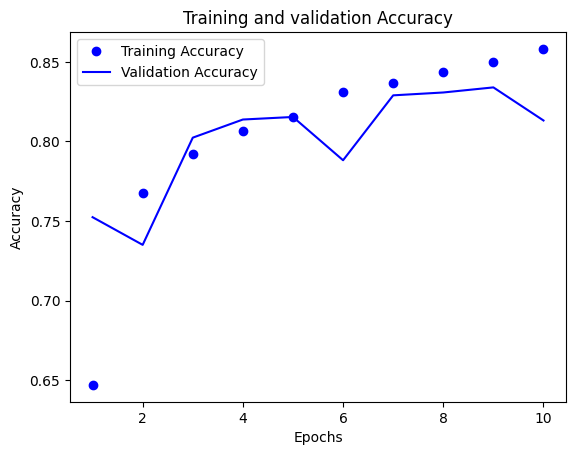

Training samples: 500
Embedding layer test accuracy: 0.827
Pretrained embeddings test accuracy: 0.836
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 48s 69ms/step - loss: 0.5240 - accuracy: 0.7286 - val_loss: 0.4217 - val_accuracy: 0.8134
Epoch 2/10
625/625 [==============================] - 36s 58ms/step - loss: 0.3474 - accuracy: 0.8586 - val_loss: 0.3560 - val_accuracy: 0.8472
Epoch 3/10
625/625 [==============================] - 18s 29ms/step - loss: 0.2930 - accuracy: 0.8834 - val_loss: 0.3600 - val_accuracy: 0.8464
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2574 - accuracy: 0.9039 - val_loss: 0.3812 - val_accuracy: 0.8524
Epoch 5/10
625/625 [==============================] - 19s 30ms/step - loss: 0.2280 - accuracy: 0.9147 - val_loss: 0.4339 - val_accuracy: 0.8504
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2051 - 

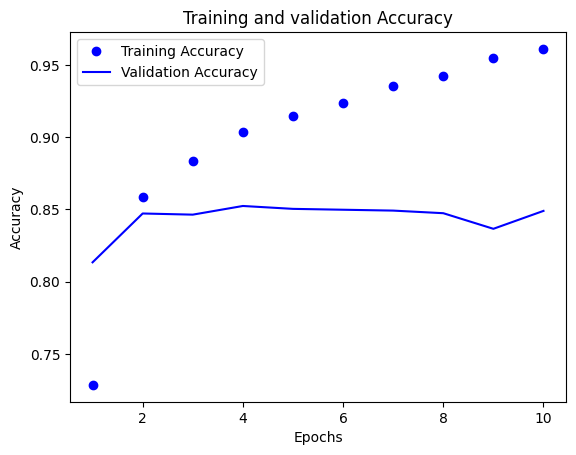

Epoch 1/10
625/625 [==============================] - 66s 94ms/step - loss: 0.5946 - accuracy: 0.6762 - val_loss: 0.5202 - val_accuracy: 0.7464
Epoch 2/10
625/625 [==============================] - 46s 74ms/step - loss: 0.4852 - accuracy: 0.7740 - val_loss: 0.4422 - val_accuracy: 0.7922
Epoch 3/10
625/625 [==============================] - 47s 75ms/step - loss: 0.4445 - accuracy: 0.7955 - val_loss: 0.4196 - val_accuracy: 0.8056
Epoch 4/10
625/625 [==============================] - 46s 74ms/step - loss: 0.4153 - accuracy: 0.8121 - val_loss: 0.3953 - val_accuracy: 0.8180
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3922 - accuracy: 0.8247 - val_loss: 0.4025 - val_accuracy: 0.8272
Epoch 6/10
625/625 [==============================] - 56s 89ms/step - loss: 0.3756 - accuracy: 0.8353 - val_loss: 0.3819 - val_accuracy: 0.8278
Epoch 7/10
625/625 [==============================] - 51s 82ms/step - loss: 0.3598 - accuracy: 0.8426 - val_loss: 0.3747 - val_accuracy:

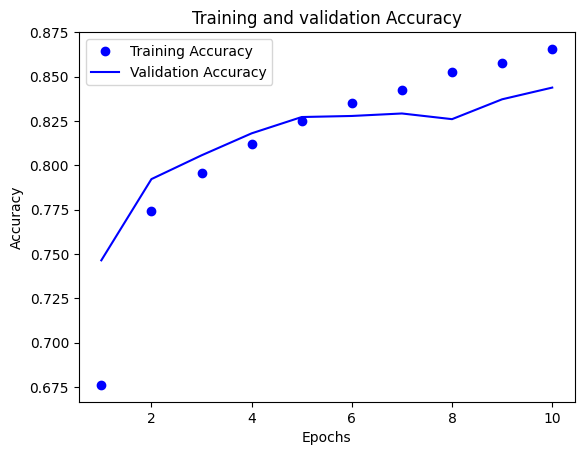

Training samples: 1000
Embedding layer test accuracy: 0.834
Pretrained embeddings test accuracy: 0.840
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 50s 69ms/step - loss: 0.5120 - accuracy: 0.7445 - val_loss: 0.3662 - val_accuracy: 0.8384
Epoch 2/10
625/625 [==============================] - 16s 26ms/step - loss: 0.3470 - accuracy: 0.8583 - val_loss: 0.3706 - val_accuracy: 0.8468
Epoch 3/10
625/625 [==============================] - 29s 47ms/step - loss: 0.2882 - accuracy: 0.8874 - val_loss: 0.3511 - val_accuracy: 0.8586
Epoch 4/10
625/625 [==============================] - 15s 23ms/step - loss: 0.2544 - accuracy: 0.9035 - val_loss: 0.3793 - val_accuracy: 0.8432
Epoch 5/10
625/625 [==============================] - 18s 28ms/step - loss: 0.2251 - accuracy: 0.9158 - val_loss: 0.4549 - val_accuracy: 0.8314
Epoch 6/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2028 -

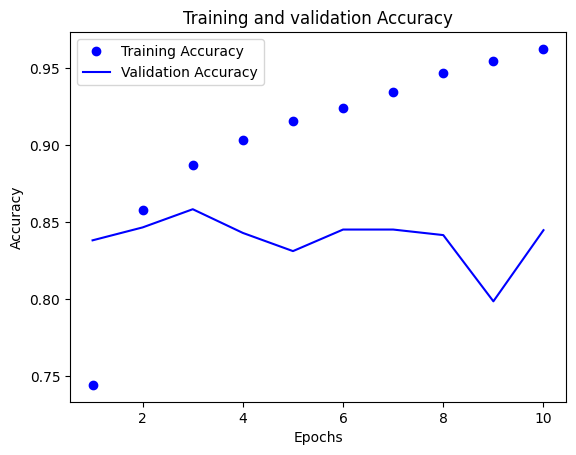

Epoch 1/10
625/625 [==============================] - 72s 98ms/step - loss: 0.5930 - accuracy: 0.6801 - val_loss: 0.5106 - val_accuracy: 0.7554
Epoch 2/10
625/625 [==============================] - 49s 79ms/step - loss: 0.4934 - accuracy: 0.7638 - val_loss: 0.4481 - val_accuracy: 0.7916
Epoch 3/10
625/625 [==============================] - 28s 45ms/step - loss: 0.4492 - accuracy: 0.7915 - val_loss: 0.4667 - val_accuracy: 0.7942
Epoch 4/10
625/625 [==============================] - 47s 75ms/step - loss: 0.4240 - accuracy: 0.8091 - val_loss: 0.4126 - val_accuracy: 0.8178
Epoch 5/10
625/625 [==============================] - 22s 35ms/step - loss: 0.3967 - accuracy: 0.8227 - val_loss: 0.4424 - val_accuracy: 0.7988
Epoch 6/10
625/625 [==============================] - 52s 84ms/step - loss: 0.3816 - accuracy: 0.8311 - val_loss: 0.4007 - val_accuracy: 0.8124
Epoch 7/10
625/625 [==============================] - 23s 37ms/step - loss: 0.3638 - accuracy: 0.8426 - val_loss: 0.4065 - val_accuracy:

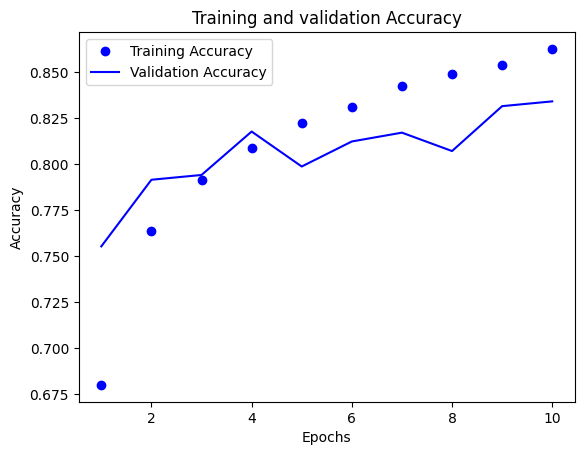

Training samples: 5000
Embedding layer test accuracy: 0.841
Pretrained embeddings test accuracy: 0.840
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 50s 72ms/step - loss: 0.5244 - accuracy: 0.7311 - val_loss: 0.4224 - val_accuracy: 0.8210
Epoch 2/10
625/625 [==============================] - 34s 54ms/step - loss: 0.3491 - accuracy: 0.8561 - val_loss: 0.3657 - val_accuracy: 0.8490
Epoch 3/10
625/625 [==============================] - 25s 40ms/step - loss: 0.2945 - accuracy: 0.8831 - val_loss: 0.3715 - val_accuracy: 0.8534
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 0.2563 - accuracy: 0.9014 - val_loss: 0.3978 - val_accuracy: 0.8380
Epoch 5/10
625/625 [==============================] - 14s 23ms/step - loss: 0.2288 - accuracy: 0.9140 - val_loss: 0.3981 - val_accuracy: 0.8452
Epoch 6/10
625/625 [==============================] - 15s 24ms/step - loss: 0.2011 -

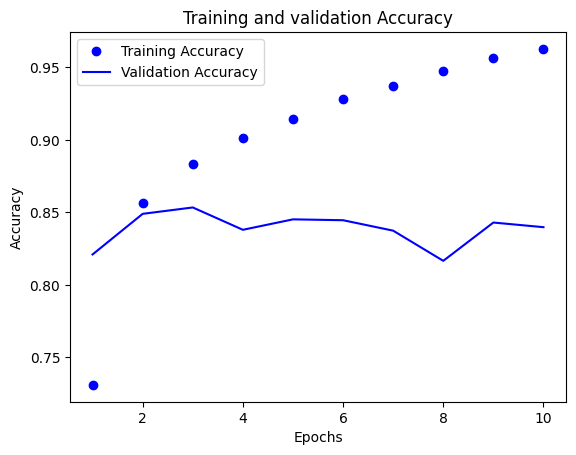

Epoch 1/10
625/625 [==============================] - 69s 96ms/step - loss: 0.6015 - accuracy: 0.6697 - val_loss: 0.5290 - val_accuracy: 0.7338
Epoch 2/10
625/625 [==============================] - 51s 82ms/step - loss: 0.4879 - accuracy: 0.7707 - val_loss: 0.4533 - val_accuracy: 0.7796
Epoch 3/10
625/625 [==============================] - 61s 98ms/step - loss: 0.4424 - accuracy: 0.7964 - val_loss: 0.4472 - val_accuracy: 0.7768
Epoch 4/10
625/625 [==============================] - 48s 77ms/step - loss: 0.4149 - accuracy: 0.8130 - val_loss: 0.4227 - val_accuracy: 0.8014
Epoch 5/10
625/625 [==============================] - 47s 75ms/step - loss: 0.3931 - accuracy: 0.8264 - val_loss: 0.4013 - val_accuracy: 0.8110
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3717 - accuracy: 0.8378 - val_loss: 0.4053 - val_accuracy: 0.8014
Epoch 7/10
625/625 [==============================] - 51s 82ms/step - loss: 0.3571 - accuracy: 0.8454 - val_loss: 0.3991 - val_accuracy:

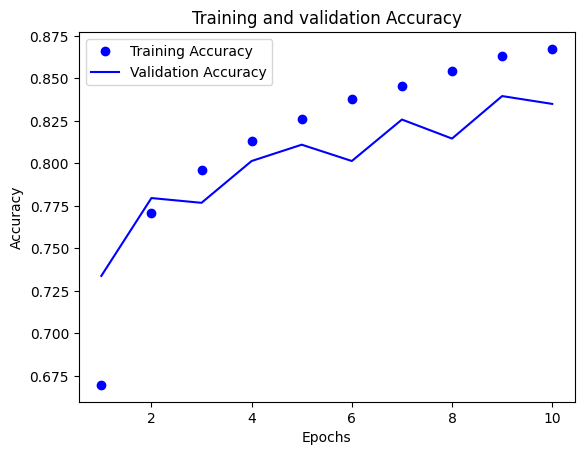

Training samples: 10000
Embedding layer test accuracy: 0.829
Pretrained embeddings test accuracy: 0.840
--------------------------------------------------
Found 20000 files belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 50s 73ms/step - loss: 0.5267 - accuracy: 0.7315 - val_loss: 0.4709 - val_accuracy: 0.8208
Epoch 2/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3536 - accuracy: 0.8561 - val_loss: 0.3438 - val_accuracy: 0.8524
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.2909 - accuracy: 0.8836 - val_loss: 0.4456 - val_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 17s 28ms/step - loss: 0.2591 - accuracy: 0.9005 - val_loss: 0.4302 - val_accuracy: 0.8464
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2320 - accuracy: 0.9129 - val_loss: 0.3826 - val_accuracy: 0.8494
Epoch 6/10
625/625 [==============================] - 17s 26ms/step - loss: 0.2055 

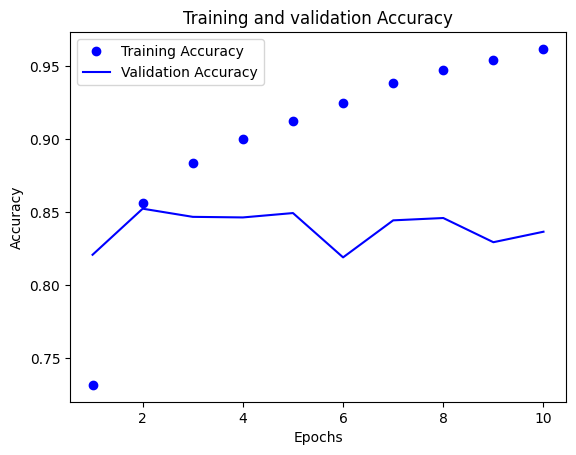

Epoch 1/10
625/625 [==============================] - 66s 88ms/step - loss: 0.5906 - accuracy: 0.6826 - val_loss: 0.4839 - val_accuracy: 0.7656
Epoch 2/10
625/625 [==============================] - 47s 75ms/step - loss: 0.4811 - accuracy: 0.7710 - val_loss: 0.4377 - val_accuracy: 0.7928
Epoch 3/10
625/625 [==============================] - 50s 81ms/step - loss: 0.4394 - accuracy: 0.7997 - val_loss: 0.4093 - val_accuracy: 0.8096
Epoch 4/10
625/625 [==============================] - 19s 30ms/step - loss: 0.4118 - accuracy: 0.8128 - val_loss: 0.4714 - val_accuracy: 0.7980
Epoch 5/10
625/625 [==============================] - 53s 85ms/step - loss: 0.3902 - accuracy: 0.8248 - val_loss: 0.3854 - val_accuracy: 0.8226
Epoch 6/10
625/625 [==============================] - 25s 39ms/step - loss: 0.3722 - accuracy: 0.8385 - val_loss: 0.3894 - val_accuracy: 0.8256
Epoch 7/10
625/625 [==============================] - 19s 30ms/step - loss: 0.3593 - accuracy: 0.8456 - val_loss: 0.4073 - val_accuracy:

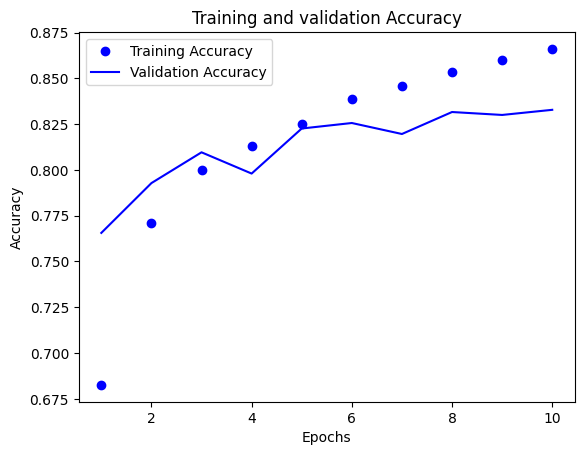

Training samples: 20000
Embedding layer test accuracy: 0.842
Pretrained embeddings test accuracy: 0.830
--------------------------------------------------


In [14]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batch_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = val_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = test_ds.map(
        lambda x, y: (text_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(max_tokens, embedding_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.x")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(1, len(accuracy) + 1)
    plt.figure()
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        max_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.x",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.x")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(1, len(accuracy) + 1)
    plt.figure()
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)